In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import cv2

# Data loading

In [2]:
input_path = '/kaggle//input//mayo-clinic-strip-ai//'

train_data = pd.read_csv(os.path.join(input_path, 'train.csv'))
test_data = pd.read_csv(os.path.join(input_path, 'test.csv'))
other_data = pd.read_csv(os.path.join(input_path, 'other.csv'))

# Data exploring

In [3]:
print(f"Number of images in training data: {train_data['image_id'].value_counts().sum()}")
print(f"Number of images in other data : {other_data['image_id'].value_counts().sum()}")
print(f"Number of images in testind data : {test_data['image_id'].value_counts().sum()}")

Number of images in training data: 754

Number of images in other data : 396

Number of images in testind data : 4


In [4]:
train_data.head(2)

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE


In [5]:
test_data.head(2)

,image_id,center_id,patient_id,image_num
0,006388_0,11,006388,0
1,008e5c_0,11,008e5c,0


In [6]:
other_data.head(2)

,image_id,patient_id,image_num,other_specified,label
0,01f2b3_0,01f2b3,0,NaN,Unknown
1,01f2b3_1,01f2b3,1,NaN,Unknown


## Data Distribution

In [7]:
labels_train = train_data["label"].value_counts()
labels_other = other_data["label"].value_counts()

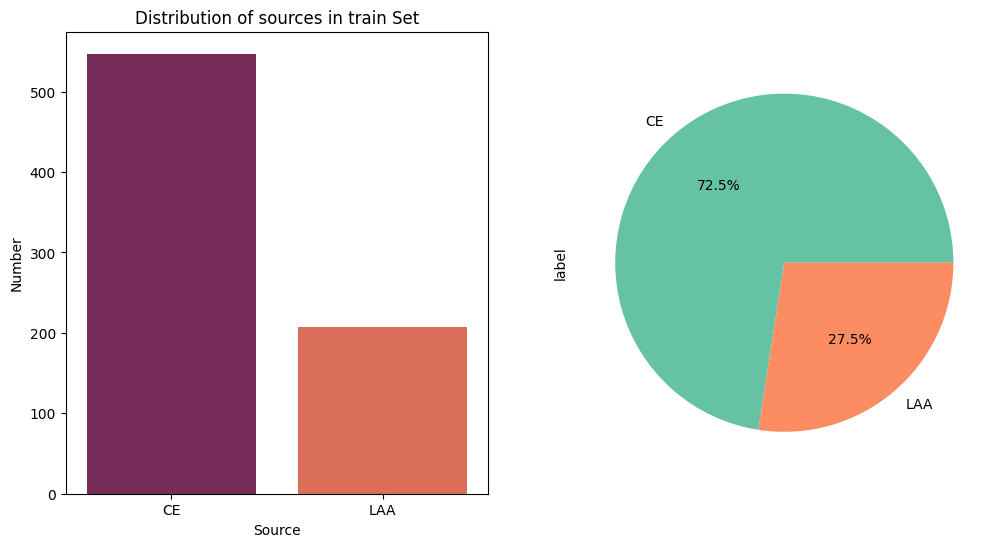

In [8]:
fig, ax1 = plt.subplots(1, 2, figsize=(12, 6))

ax = sns.barplot(x=labels_train.index, y=labels_train.values, palette="rocket", ax=ax1[0])
ax1[0].set_title("Distribution of sources in train Set")
ax1[0].set_ylabel("Number")
ax1[0].set_xlabel("Source")

train_data["label"].value_counts().plot.pie(autopct='%1.1f%%', ylabel="label", colors=sns.color_palette('Set2'), ax=ax1[1])
ax1[1].set_xlabel("") 

plt.show()

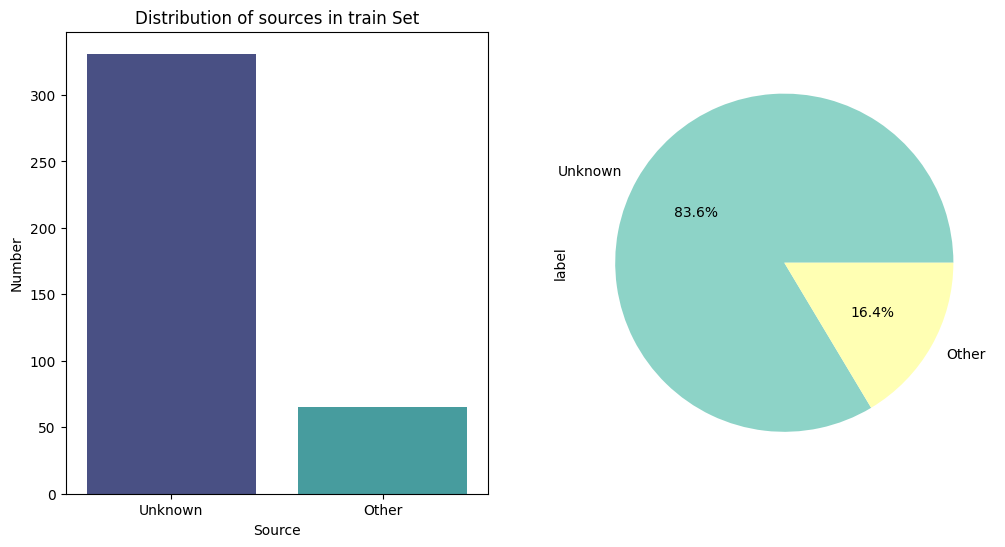

In [9]:
fig, ax1 = plt.subplots(1, 2, figsize=(12, 6))

ax = sns.barplot(x=labels_other.index, y=labels_other.values, palette="mako", ax=ax1[0])
ax1[0].set_title("Distribution of sources in train Set")
ax1[0].set_ylabel("Number")
ax1[0].set_xlabel("Source")

other_data["label"].value_counts().plot.pie(autopct='%1.1f%%', ylabel="label", colors=sns.color_palette('Set3'), ax=ax1[1])
ax1[1].set_xlabel("") 

plt.show()

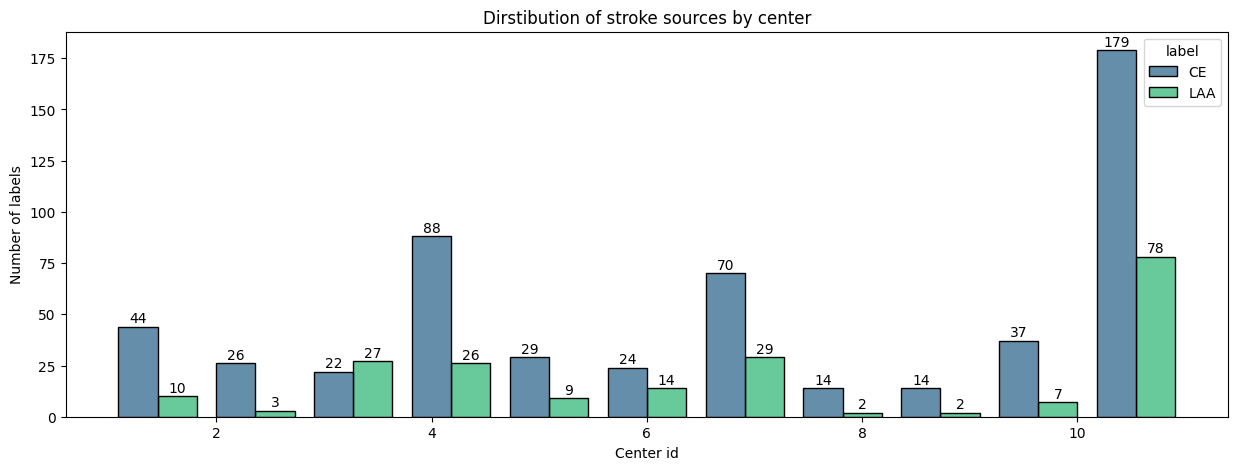

In [10]:
plt.figure(figsize=(15,5))
g = sns.histplot(data=train_data, x="center_id", hue="label", multiple="dodge", color='label', palette="viridis",
                  shrink=0.8)

g.set(xlabel='Center id', ylabel='Number of labels')
for p in g.patches:
    x, w, h = p.get_x(), p.get_width(), p.get_height()
    if h > 0:
        g.annotate(f'{h}\n', (x + w / 2, h), ha='center', va='center', size=10)
g.set_title('Dirstibution of stroke sources by center')

plt.show()

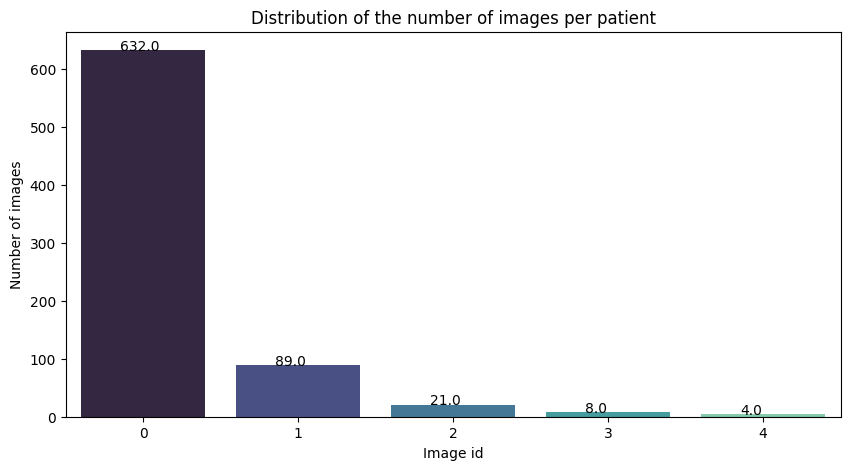

In [11]:
plt.figure(figsize=(10,5))

ax = sns.countplot(x="image_num", data=train_data,palette="mako",)
ax.set(xlabel='Image id', ylabel='Number of images')
ax.set_title('Distribution of the number of images per patient')
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.show()

# Images exploring


In [12]:
from glob import glob
from PIL import Image
from openslide import OpenSlide
from collections import defaultdict
import concurrent.futures
Image.MAX_IMAGE_PIXELS = None

In [13]:
train_images = glob("/kaggle/input/mayo-clinic-strip-ai/train/*")
test_images = glob("/kaggle/input/mayo-clinic-strip-ai/test/*")
other_images = glob("/kaggle/input/mayo-clinic-strip-ai/other/*")

In [14]:
image_specifications = defaultdict(list)
for i, path in enumerate(train_images):
    img_path = train_images[i]
    slide = OpenSlide(img_path)    
    image_specifications['image_id'].append(img_path[-12:-4])
    image_specifications['width'].append(slide.dimensions[0])
    image_specifications['height'].append(slide.dimensions[1])
    image_specifications['size'].append(round(os.path.getsize(img_path) / 1e6, 2))
    image_specifications['path'].append(img_path)
image_data = pd.DataFrame(image_specifications)
image_data['img_aspect_ratio'] = image_data['width']/image_data['height']
image_data = image_data.merge(train_data, on='image_id')

In [15]:
image_data.head(2)

,image_id,width,height,size,path,img_aspect_ratio,center_id,patient_id,image_num,label
0,a4c7df_0,30732,55283,449.15,/kaggle/input/mayo-clinic-strip-ai/train/a4c7d...,0.555903,11,a4c7df,0,LAA
1,f9fc6b_0,38398,65388,298.40,/kaggle/input/mayo-clinic-strip-ai/train/f9fc6...,0.587233,11,f9fc6b,0,LAA


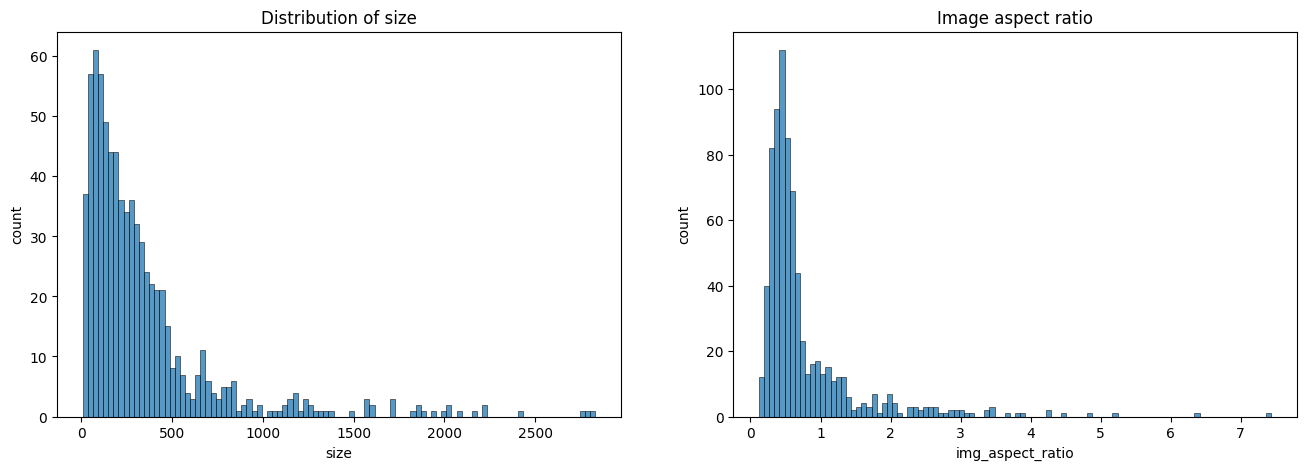

In [16]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.histplot(x='size', data = image_data, bins=100, ax=ax[0])
ax[0].set_title("Distribution of size"), ax[0].set_ylabel("count")
sns.histplot(x='img_aspect_ratio', data = image_data, bins=100, ax=ax[1])
ax[1].set_title("Image aspect ratio"), ax[1].set_ylabel("count")
plt.show()

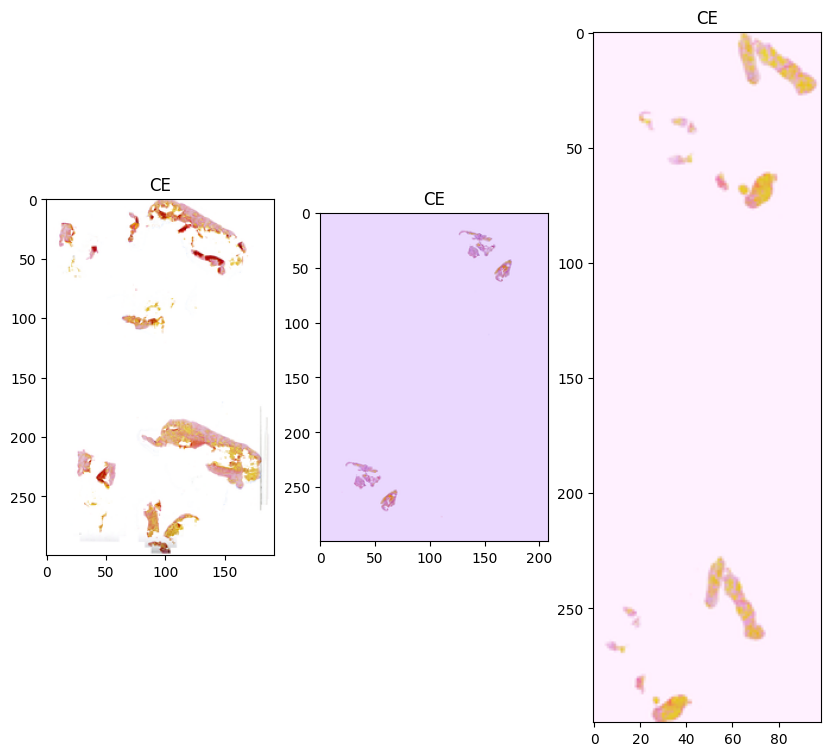

In [17]:
CE_imgs = image_data.loc[image_data['label']=='CE','path']
LAA_imgs = image_data.loc[image_data['label']=='LAA','path']

def minify_img(img_path):
    img = Image.open(img_path)
    img.thumbnail((300, 300), Image.Resampling.LANCZOS)
    return img

with concurrent.futures.ThreadPoolExecutor() as executor:
    CE_images = list(executor.map(minify_img, np.random.choice(CE_imgs, 3)))

plt.style.use('default')
fig, axes = plt.subplots(1, 3, figsize=(10, 10))
for ax, img in zip(axes.reshape(-1), CE_images):
    ax.imshow(img)
    ax.set_title("CE")

plt.show()

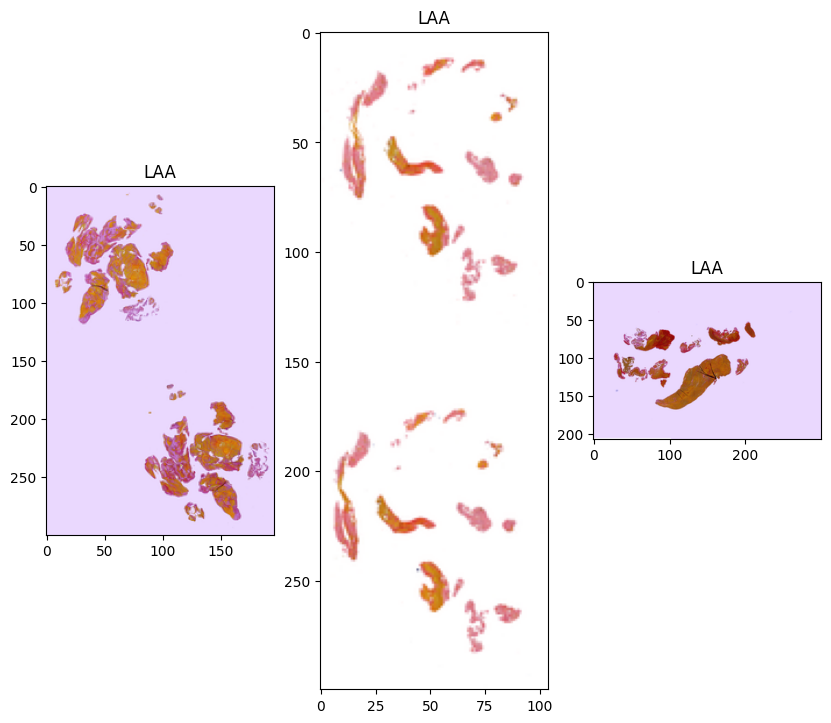

In [18]:
def minify_img(img_path):
    img = Image.open(img_path)
    img.thumbnail((300, 300), Image.Resampling.LANCZOS)
    return img

with concurrent.futures.ThreadPoolExecutor() as executor:
    LAA_images = list(executor.map(minify_img, np.random.choice(LAA_imgs, 3)))

plt.style.use('default')
fig, axes = plt.subplots(1,3, figsize=(10, 10))
for ax, img in zip(axes.reshape(-1), LAA_images):
    ax.imshow(img)
    ax.set_title("LAA")

plt.show()